In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_benechmark = pd.read_excel("benechmark_experiments.xlsx")
sumo_exp = pd.read_excel("sumo exp.xlsx")

In [ ]:
data_benechmark

In [3]:
data_benechmark.columns

Index(['Data', 'Action space', 'Reward', 'Max sumo steps', 'Seeds',
       'Traffic Scale', 'Run', 'Total Reward', 'Waiting', 'Speed',
       'Depart Delay', 'Time Loss', 'Waiting Car', 'Total Time(m)', 'Person',
       'Device', 'Notes'],
      dtype='object')

In [4]:
column_x = 'Max sumo steps'
numeric_target_columns = ['Total Reward', 'Waiting', 'Speed','Depart Delay', 'Time Loss', 'Waiting Car', 'Total Time(m)']

## Helper Functions

In [6]:
import datetime
def clean_datatime(value):
        if isinstance(value, datetime.datetime):          
            return value.month + value.day * 0.01
        elif isinstance(value, str):
            return float(value)
        else:
            return value
        
def clean_columns_datatime(data):
    for column in ['Seeds', 'Total Reward', 'Waiting', 'Speed','Depart Delay', 'Time Loss', 'Waiting Car', 'Total Time(m)']:
        if column in data.columns:
            data.loc[:, column] = data[column].apply(lambda x: clean_datatime(x))
    return data

def get_grouped_seed(data): ## seeds are after each other on same experiments
    df = data.reset_index(drop=True)
    result_rows = []
    i = 0

    while i < len(df) - 2:
        group = df.iloc[i:i+3]
        if set(group['Seeds']) == {0, 1, 2}:  # Check if Seeds are 0, 1, 2
            # Average numeric columns
            numeric_cols = group.select_dtypes(include='number').columns
            avg_numeric = group[numeric_cols].mean()
            
            # Keep non-numeric columns from the first row
            non_numeric_cols = group.select_dtypes(exclude='number').columns
            non_numeric = group.iloc[0][non_numeric_cols]
            
            # Combine into a single averaged row
            new_row = pd.concat([non_numeric, avg_numeric])
            result_rows.append(new_row)
            
            i += 3  # Skip the group of 3 rows
        else:
            result_rows.append(df.iloc[i])  # Add this row as is
            i += 1

    # Add any remaining rows that were not part of a group
    while i < len(df):
        result_rows.append(df.iloc[i])
        i += 1

    # Create the final DataFrame
    result_df = pd.DataFrame(result_rows)

    # Now result_df contains the modified DataFrame with averaged rows
    return result_df




In [7]:
def prepare_data_benechmark(Area,scale,run_type):
    # get  data for wanted attributes
    data_area_1 = data_benechmark[data_benechmark['Data']==Area]
    data_area_run = data_area_1[data_area_1['Run']==run_type]
    data_scaled = data_area_run[data_area_run['Traffic Scale']==scale]

    #clean numeric datatime
    data_scaled = clean_columns_datatime(data_scaled)

    # makedata groubed on seed
    data_groubed_Seed = get_grouped_seed(data_scaled)
    return data_scaled,data_groubed_Seed

def prepare_data_sumo(Area,scale):
    data_area_1 = sumo_exp[sumo_exp['Data']==Area]
    data_scaled = data_area_1[data_area_1['Scale']==scale]
    data_scaled = clean_columns_datatime(data_scaled)
    return data_scaled

In [19]:
def plot_data_around_seed(data,data_groubed,column_x,column_y, title='',label='',marker='--',color='blue'):
    
    for i in range(3):
        plt.plot(data[data['Seeds']==i][column_x],data[data['Seeds']==i][column_y], label =f'seed {i} with {label}',linestyle=marker,alpha=.7,linewidth=1.5)
        #print(f"Plotting seed {i} for {column_y}, length={len(data[data['Seeds']==i])}")

    plt.plot(data_groubed[column_x],data_groubed[column_y],label ='average'+label,linestyle='-',color=color,linewidth=2.5)
    plt.title(title)
    plt.xlabel(column_x)
    plt.ylabel(column_y)


In [9]:
def set_title(column_x,column_y):
    if column_x == 'Max sumo steps':
        x_label = 'Max sumo steps (s)'
    else:
        x_label = column_x
    if column_y == 'Total Reward':
        y_label = 'Total Reward'
    elif column_y == 'Waiting':
        y_label = 'Waiting time (s)'
    elif column_y == 'Speed':
        y_label = 'Average Speed (m/s)'
    elif column_y == 'Depart Delay':
        y_label = 'Depart Delay (s)'
    elif column_y == 'Time Loss':
        y_label = 'Time Loss (s)'
    elif column_y == 'Waiting Car':
        y_label = 'Waiting Cars'
    elif column_y == 'Total Time(m)':
        y_label = 'Total Running Time (m)'
    return f'Affect of {x_label} on {y_label}'

In [10]:
def plot_data(data_project,data_project_groubed,data_proposed,data_proposed_grouped,sumo_data):
    n = len(numeric_target_columns)
    cols = 2
    rows = (n + 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axs = axs.flatten()

    for idx, column_y in enumerate(numeric_target_columns):
        plt.sca(axs[idx])
        title = set_title(column_x,column_y)#f'Affect of {column_x} on {column_y}'

        plot_data_around_seed(
            data_project,
            data_project_groubed,
            column_x=column_x,
            column_y=column_y,
            label='Project',
            marker='--',
            color='blue'
        )

        plot_data_around_seed(
            data_proposed,
            data_proposed_grouped,
            column_x=column_x,
            column_y=column_y,
            label='Proposed',
            marker=':',
            color='purple'

        )
        if column_y in sumo_data.columns:
            plt.plot(
                sumo_data[column_x],
                sumo_data[column_y],
                label='Sumo',
                linestyle='-',
                color='green',
                linewidth=2.5
            )

        axs[idx].set_title(title)
        axs[idx].legend()

    # Hide unused axes if any
    for j in range(len(numeric_target_columns), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


## Plotting

### Plotting for Area 1 ,Scale Normal (14%)

In [11]:
Area= "Area 1"
scale = "Normal (.14)"

In [12]:
data_area_scaled_project,data_area_scaled_project_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Project') 
data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Proposed') 
data_area_scaled_sumo = prepare_data_sumo(Area= Area,scale = scale)

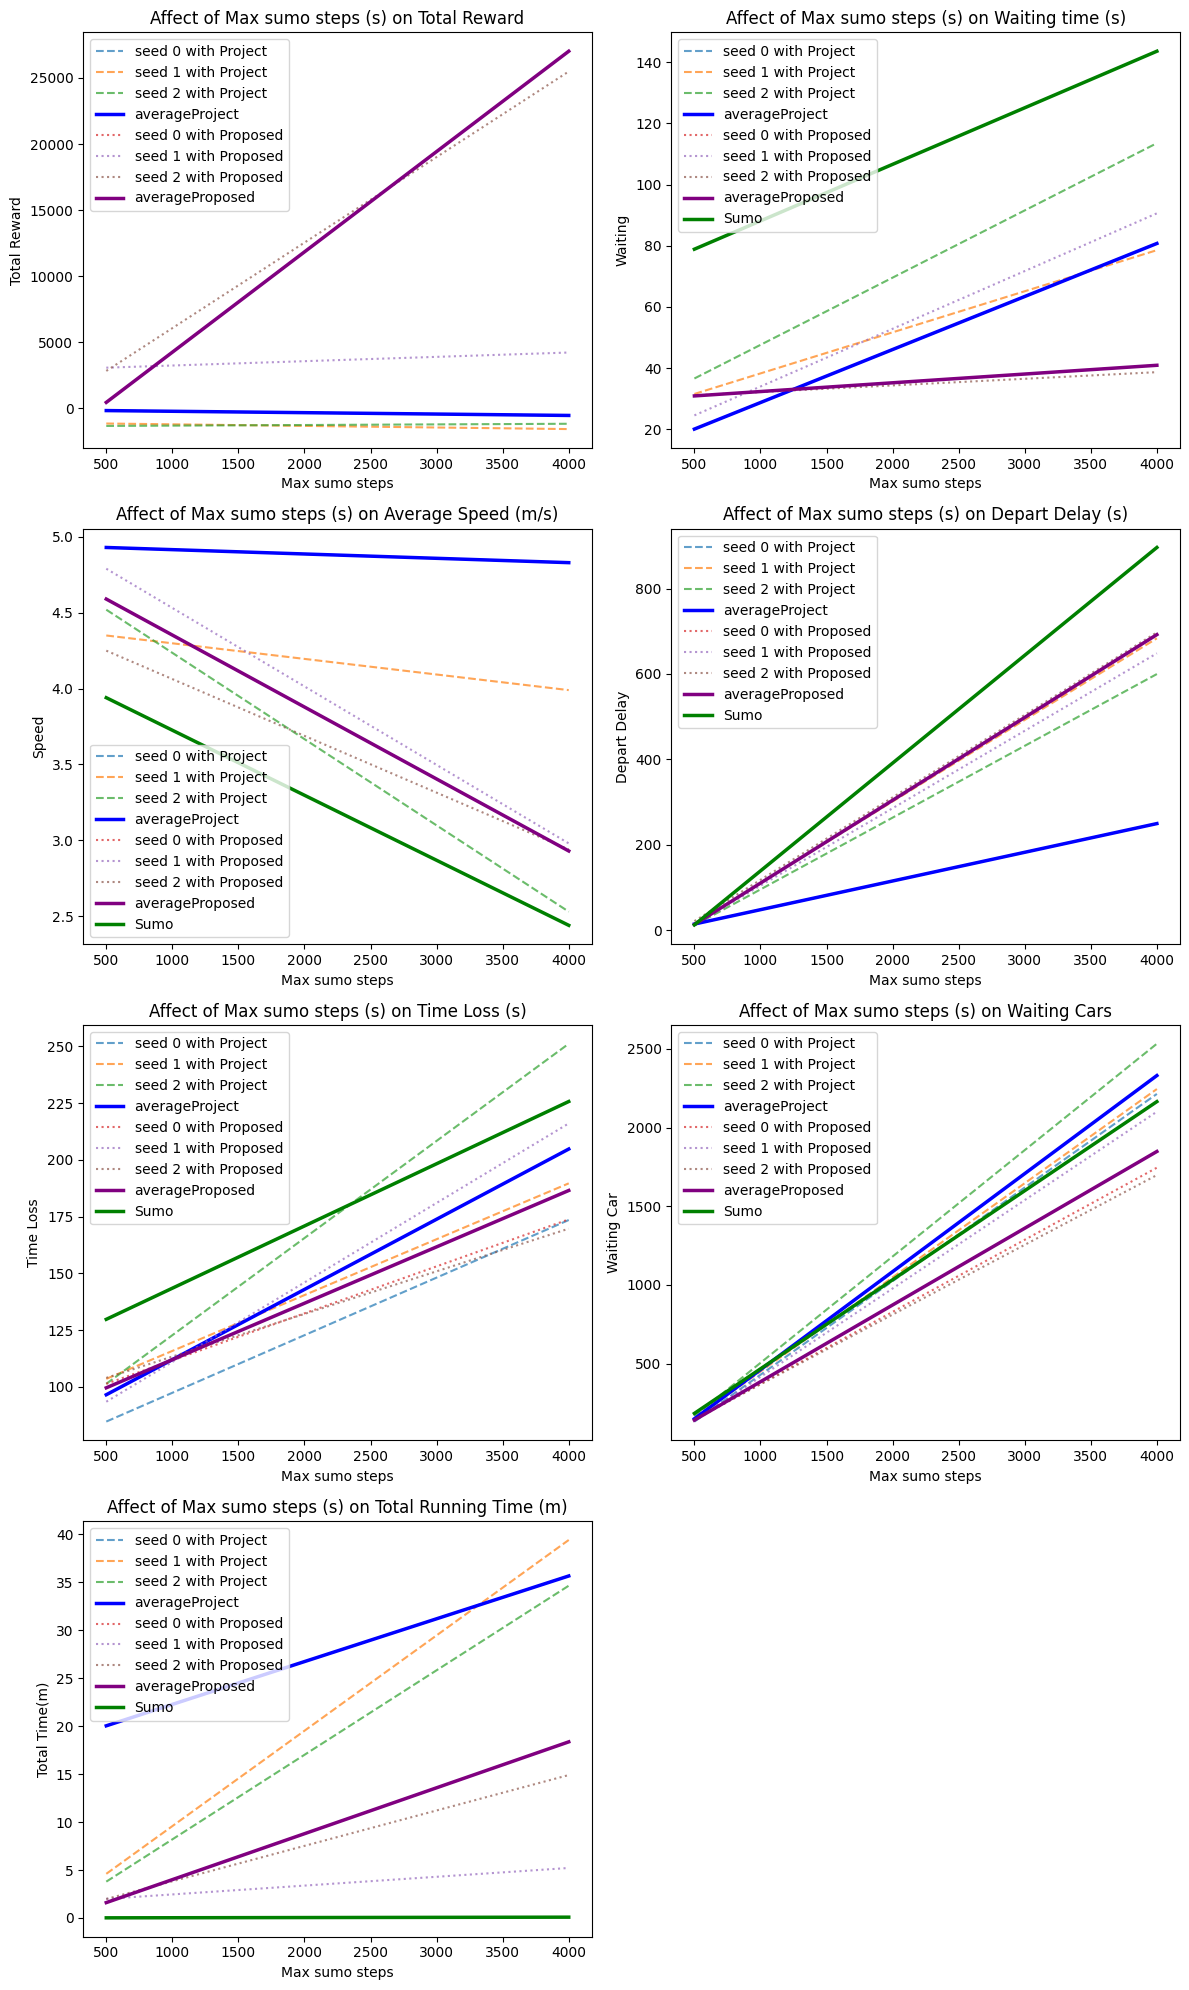

In [20]:
plot_data(data_area_scaled_project,data_area_scaled_project_seeds_mean,data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean,data_area_scaled_sumo)

**Summary of the Plot :**

- The proposed algorithm was observed to perform best in terms of reward, waiting time,waiting vehicles, and time loss.

- The reference algorithm was better in both basic SUMO and the proposed algorithm in speed, departure delay.

- The shortest execution time was recorded for basic SUMO, followed by the proposed algorithm, while the reference algorithm required the most time.

- Higher variance across different seeds was noted in the metrics of speed, departure delay, and time.

**Note** : some lines are not appear just visual/ styling-related ,when line width is set to 15 it appear

### Plotting for Area 1 ,Scale Crowded (38%)

In [31]:
Area= "Area 1"
scale = "Crowded (.38)"

In [32]:
data_area_scaled_project,data_area_scaled_project_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Project') 
data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Proposed') 
data_area_scaled_sumo = prepare_data_sumo(Area= Area,scale = scale)

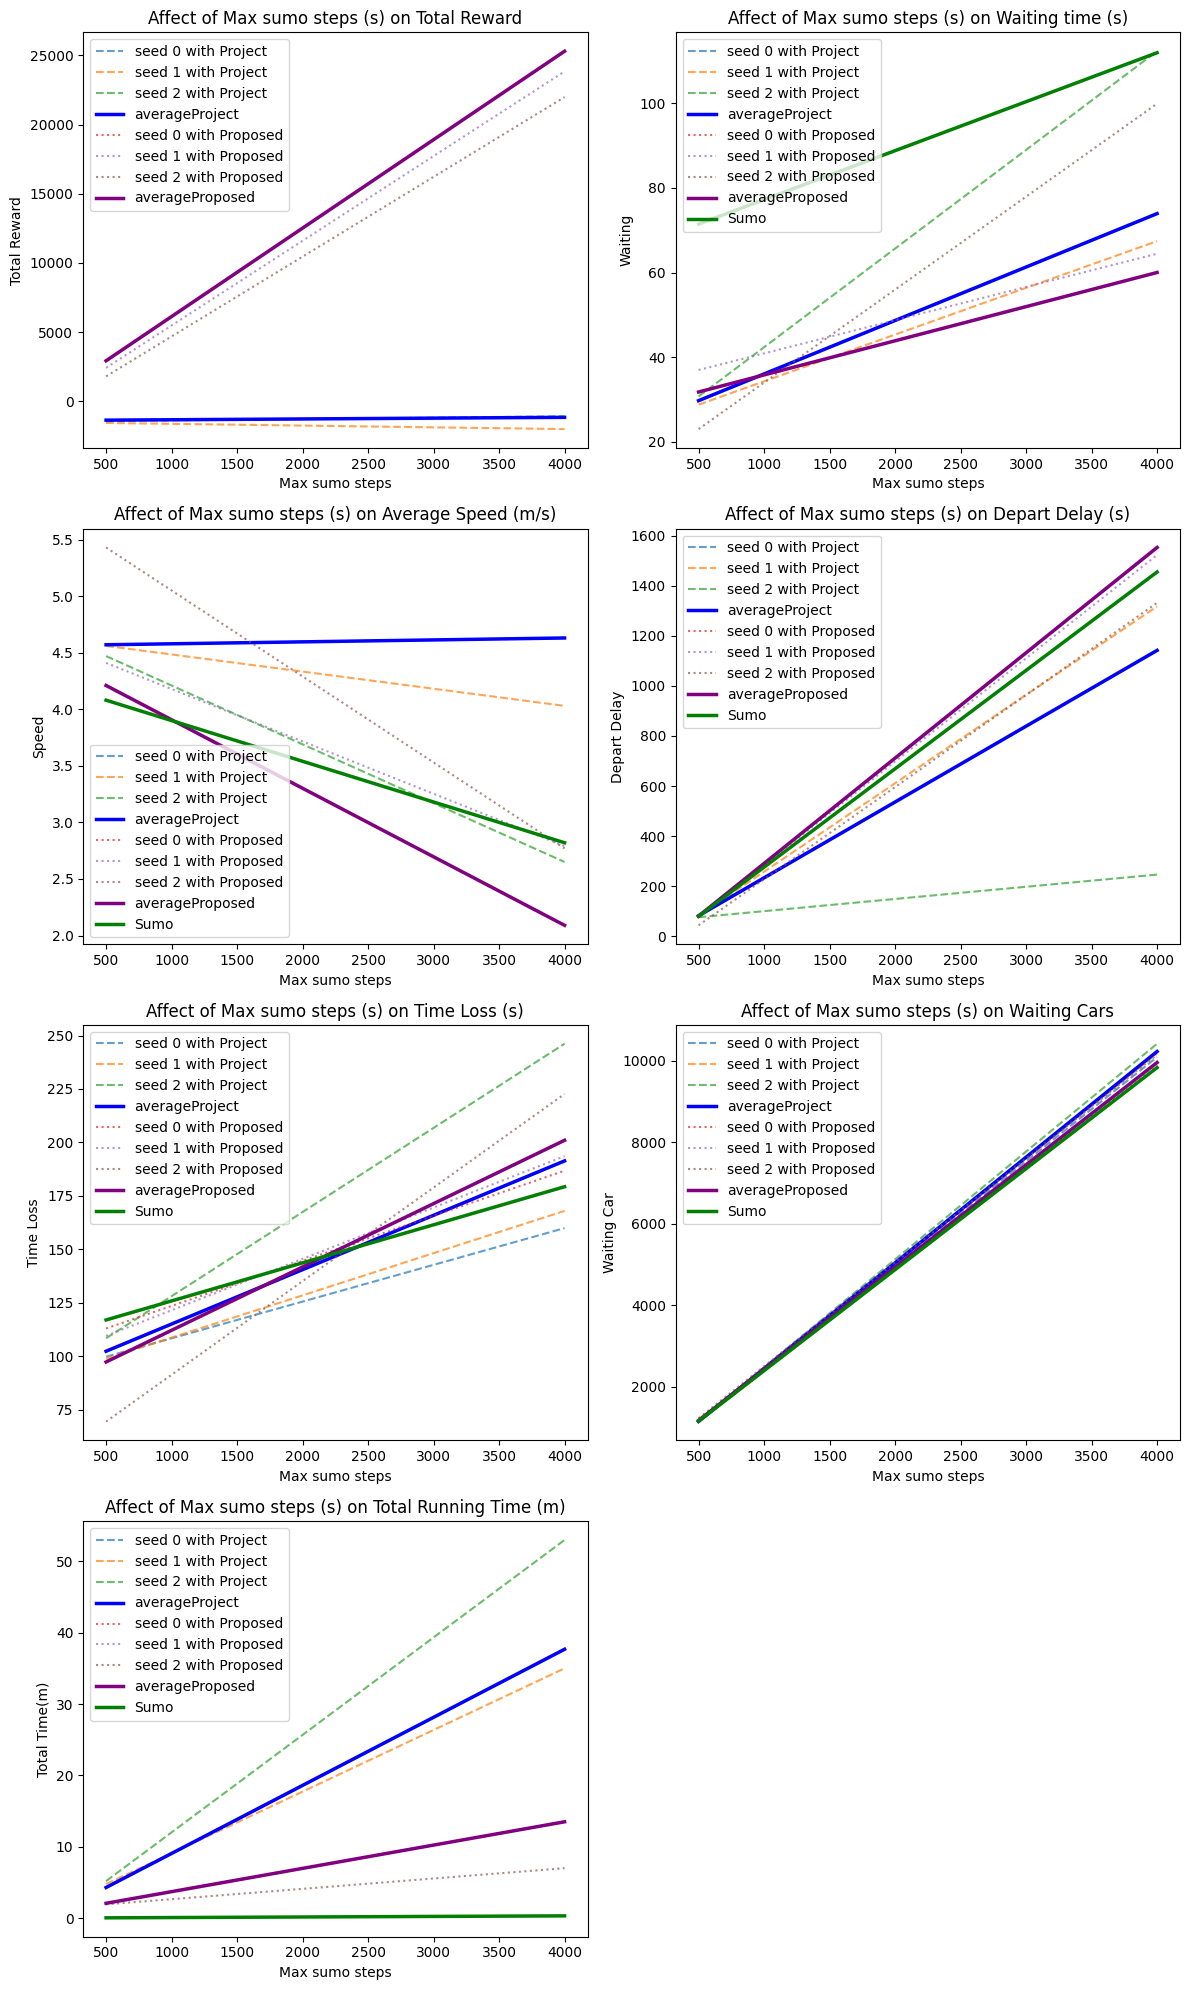

In [33]:
plot_data(data_area_scaled_project,data_area_scaled_project_seeds_mean,data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean,data_area_scaled_sumo)

**Summary of the Plot :**

- The proposed algorithm was observed to perform best in terms of reward, waiting time.

- The reference algorithm was better in both basic SUMO and the proposed algorithm in speed, departure delay.

- The shortest execution time was recorded for basic SUMO, followed by the proposed algorithm, while the reference algorithm required the most time.

- Higher variance across different seeds was noted in the metrics of speed, departure delay,Waiting Time, and Running time.

- In terms of time loss ,waiting car, the values were found to be approximately equal or very close across the algorithms.

### Plotting for Area 2 ,Scale Normal (14%)

In [34]:
Area= "Area 2"
scale = "Normal (.14)"

In [35]:
data_area_scaled_project,data_area_scaled_project_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Project') 
data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Proposed') 
data_area_scaled_sumo = prepare_data_sumo(Area= Area,scale = scale)

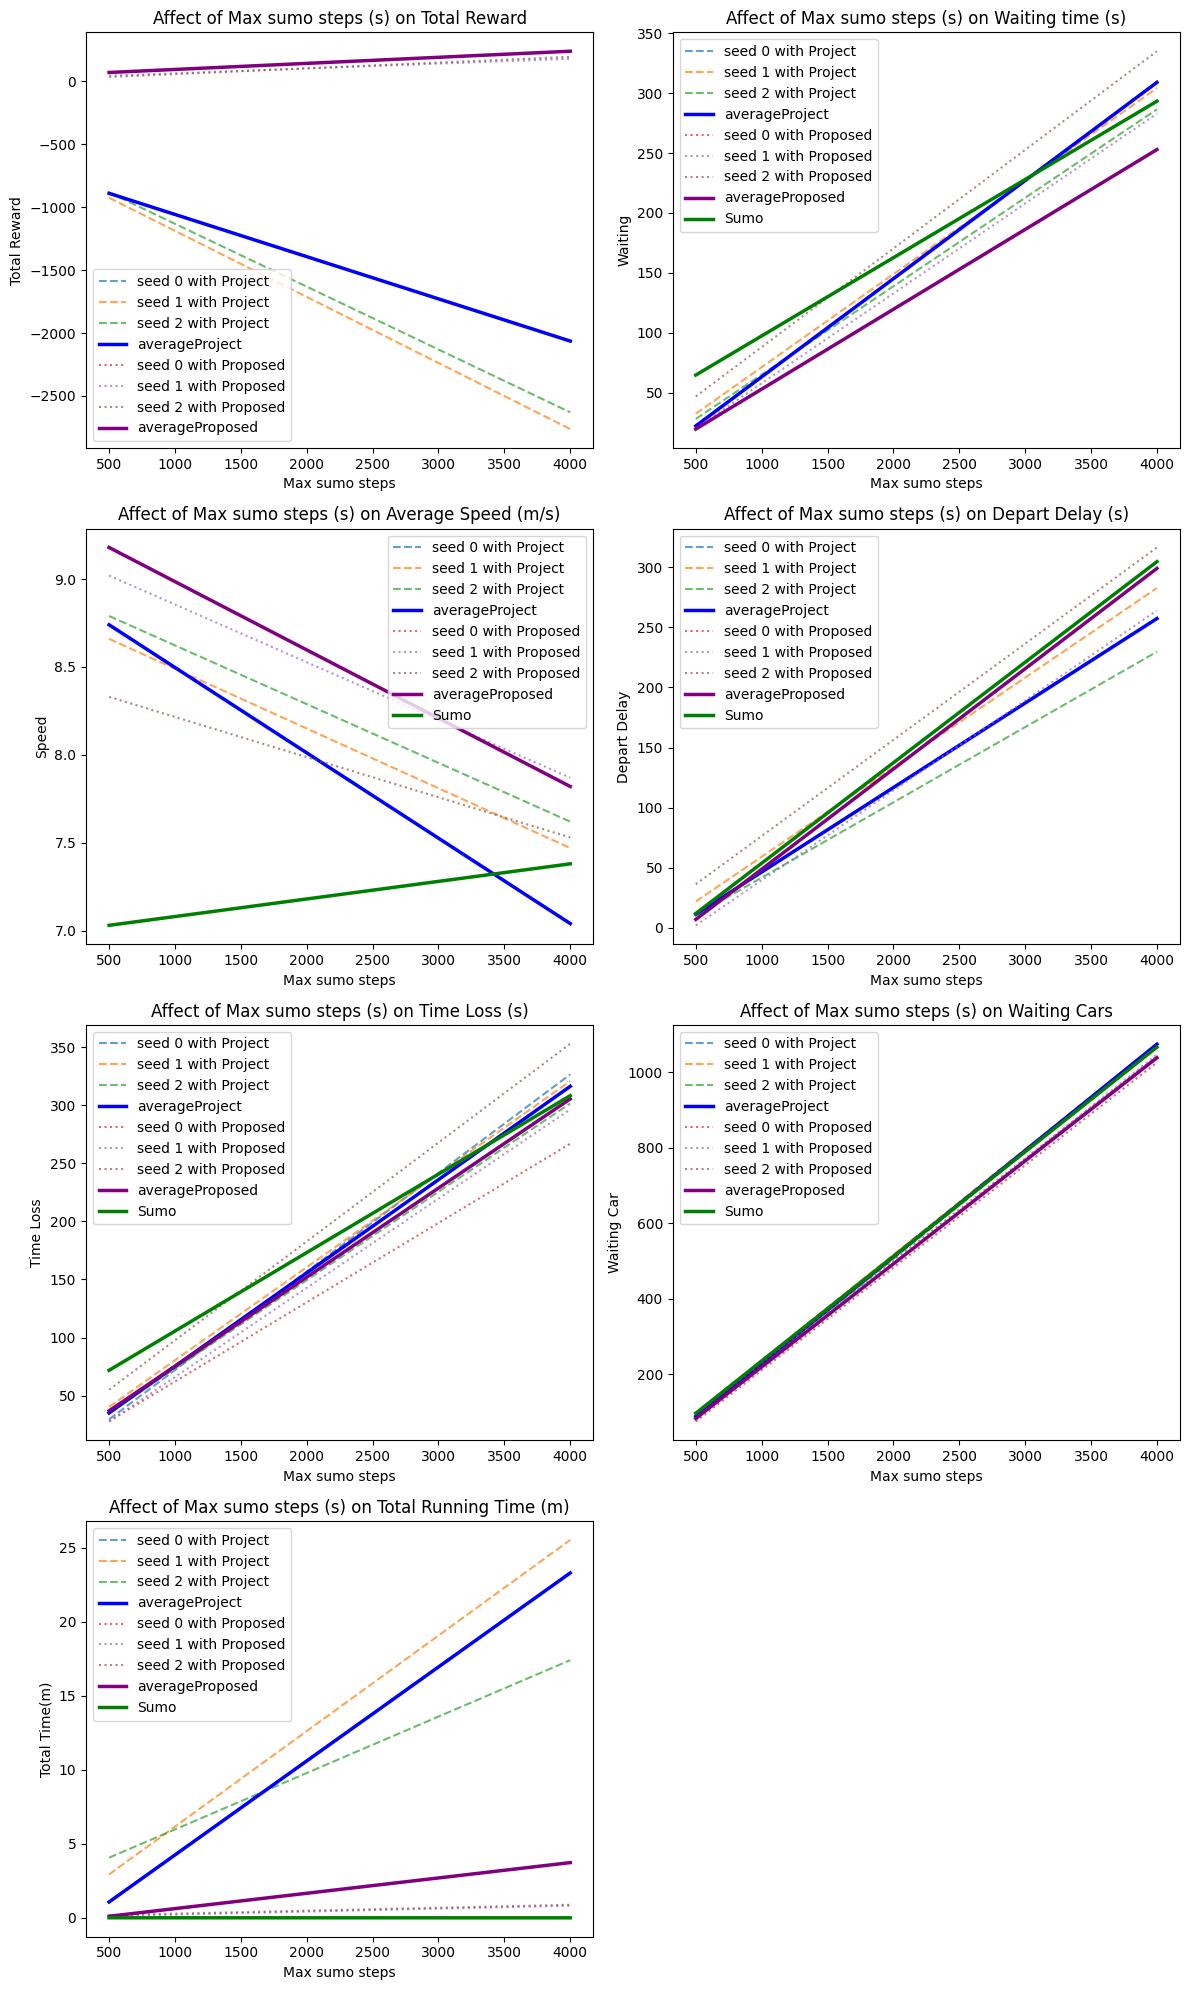

In [36]:
plot_data(data_area_scaled_project,data_area_scaled_project_seeds_mean,data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean,data_area_scaled_sumo)

**Summary of the Plot :**

- The proposed algorithm was observed to perform best in terms of reward, waiting time,speed ,waiting vehicles,time loss.

- The shortest execution time was recorded for basic SUMO, followed by the proposed algorithm, while the reference algorithm required the most time.

- In terms of time loss ,waiting car,depart delay the values were found to be approximately equal or very close across the algorithms.

### Plotting for Area 2 ,Scale Crowded (38%)

In [37]:
Area= "Area 2"
scale = "Crowded (.38)"

In [38]:
data_area_scaled_project,data_area_scaled_project_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Project') 
data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean = prepare_data_benechmark(Area= Area,scale = scale,run_type='Proposed') 
data_area_scaled_sumo = prepare_data_sumo(Area= Area,scale = scale)

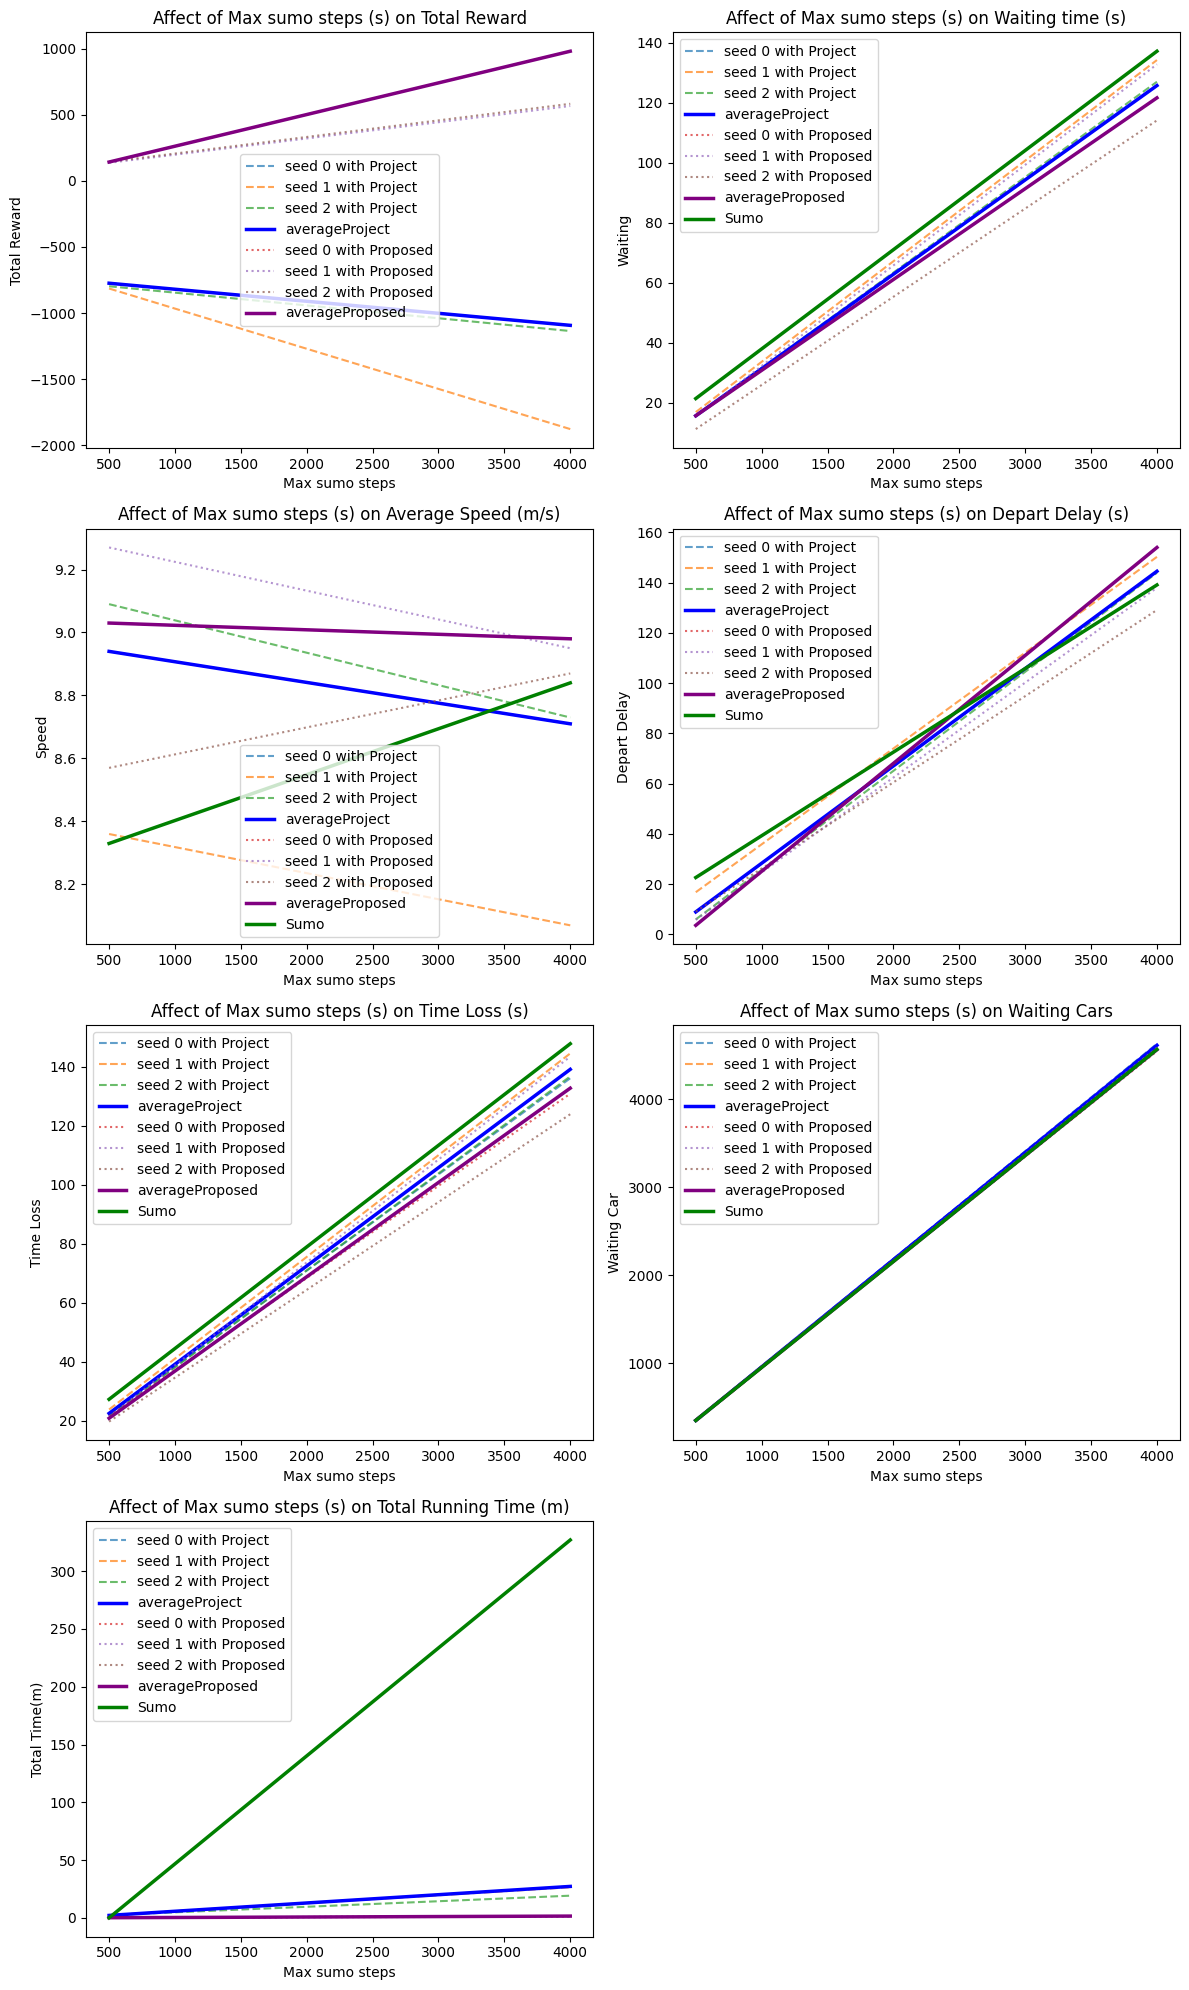

In [39]:
plot_data(data_area_scaled_project,data_area_scaled_project_seeds_mean,data_area_scaled_proposed,data_area_scaled_proposed_seeds_mean,data_area_scaled_sumo)

**Summary of the Plot :**

- The proposed algorithm was observed to perform best in terms of reward, waiting time ,speed ,time loss.

- The reference algorithm was better in both basic SUMO and the proposed algorithm in departure delay.

- The shortest execution time was recorded for proposed algorithm, followed by the reference project, followed by basic sumo.

- Higher variance across different seeds was noted in the metrics of speed.

- In terms of time loss ,waiting car,waiting time ,depart delay the values were found to be approximately equal or very close across the algorithms.

## Anova

In [41]:
df_data_benechmark = data_benechmark[['Seeds', 'Traffic Scale', 'Run', 'Total Reward', 'Waiting', 'Speed', 'Depart Delay', 'Time Loss', 'Waiting Car', 'Total Time(m)']]


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Q("Total Reward") ~ C(Seeds) * C(Q("Traffic Scale")) * C(Run)', data=df_data_benechmark).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


## Conclusion 
- The proposed environment was observed to outperform both basic SUMO and the reference project in many scenarios, and in most cases overall.

- The performance improvement may stem from multiple low-level design choices and default configurations embedded within Stable-Baselines3. These include critical hyperparameters such as target_update_interval, train_freq, and learning_starts, which were not explicitly set in the earlier implementation. Furthermore, the transition to PyTorch and potential architectural differences in the environment or training loop could also contribute. Reinforcement learning is inherently stochastic and highly sensitive to these configurations, meaning even subtle differences can lead to significant changes in learning dynamics and final performance.

- Certain performance metrics were found to be highly sensitive to random seeds, indicating variability across runs.